# Capstone: Anomaly Detection in Healthcare Claims Data
## By Ramzi Abujamra

In [5]:
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Settings
get_ipython().run_line_magic('matplotlib', 'inline')
#pd.describe_option('display')
pd.set_option('display.max_columns', None)  
pd.set_option('display.min_rows', 1) # combined with max_rows to show all rows 
pd.set_option('display.max_rows', None) 
pd.options.display.float_format = '{:.4f}'.format

## ETL

In [6]:
# Read data file - B

file = "../data/Medicare/Medicare_Provider_Util_Payment_PUF_CY2017.txt"
CMS = pd.read_csv(file, delimiter="\t")

CMS = CMS.iloc[1:]
CMS.dropna(subset=['npi'], inplace=True)
CMS = CMS.loc[(CMS.npi != 0000000000)] # & (CMS['hcpcs_drug_indicator'] == 'N')]
CMS = CMS[['npi', 'nppes_provider_gender', 'provider_type', 'medicare_participation_indicator',
           'place_of_service', 'hcpcs_drug_indicator', 'hcpcs_code', 'average_Medicare_allowed_amt', 'average_Medicare_payment_amt',
           'average_Medicare_standard_amt', 'average_submitted_chrg_amt', 'bene_day_srvc_cnt',
           'bene_unique_cnt', 'line_srvc_cnt']]


/Users/joehaber/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(CMS.shape)
CMS.head() 

(9847443, 14)


,npi,nppes_provider_gender,provider_type,medicare_participation_indicator,place_of_service,hcpcs_drug_indicator,hcpcs_code,average_Medicare_allowed_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,average_submitted_chrg_amt,bene_day_srvc_cnt,bene_unique_cnt,line_srvc_cnt
1,1003000126,M,Internal Medicine,Y,F,N,99217,73.3988,56.8272,57.4924,325.7800,100.0000,96.0000,100.0000
2,1003000126,M,Internal Medicine,Y,F,N,99218,100.0800,78.4600,79.3062,449.0000,26.0000,25.0000,26.0000
3,1003000126,M,Internal Medicine,Y,F,N,99219,136.3800,102.8077,103.8954,614.0000,52.0000,51.0000,52.0000
4,1003000126,M,Internal Medicine,Y,F,N,99220,190.3637,141.2936,142.8658,755.9322,59.0000,59.0000,59.0000
5,1003000126,M,Internal Medicine,Y,F,N,99221,101.6800,79.7100,80.7500,462.8125,16.0000,16.0000,16.0000


In [8]:
# Read data file - D

file2 = "../data/MedicareD/PartD_Prescriber_PUF_NPI_Drug_17.txt"
CMSD = pd.read_csv(file2, delimiter="\t")


CMSD = CMSD.iloc[1:]
CMSD.dropna(subset=['npi'], inplace=True)
CMSD = CMSD.loc[CMSD.npi != 0000000000]

In [9]:
print(CMSD.shape)
CMSD.head() 

(25209129, 21)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
1,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,ATORVASTATIN CALCIUM,ATORVASTATIN CALCIUM,11.0000,27,27.0000,765,259.4800,nan,#,nan,#,nan,nan,nan
2,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,CEPHALEXIN,CEPHALEXIN,17.0000,17,17.0000,123,98.9900,nan,#,nan,#,nan,nan,nan
3,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,CIPROFLOXACIN HCL,CIPROFLOXACIN HCL,11.0000,12,12.0000,95,120.4300,nan,*,nan,*,nan,nan,nan
4,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,DOXYCYCLINE HYCLATE,DOXYCYCLINE HYCLATE,17.0000,17,17.0000,105,300.7600,nan,#,nan,#,nan,nan,nan
5,1003000126,ENKESHAFI,ARDALAN,CUMBERLAND,MD,Internal Medicine,S,FUROSEMIDE,FUROSEMIDE,14.0000,22,22.0000,595,97.3300,14.0000,NaN,22.0000,NaN,22.0000,595.0000,97.3300


In [43]:
# ck nulls
CMS.isna().sum()

npi                                      0
nppes_provider_gender               431318
provider_type                            0
medicare_participation_indicator         0
place_of_service                         0
hcpcs_drug_indicator                     0
hcpcs_code                               0
average_Medicare_allowed_amt             0
average_Medicare_payment_amt             0
average_Medicare_standard_amt            0
average_submitted_chrg_amt               0
bene_day_srvc_cnt                        0
bene_unique_cnt                          0
line_srvc_cnt                            0
dtype: int64

In [10]:
# drop nulls for gender
CMS.dropna(subset=['nppes_provider_gender'], inplace=True)

In [11]:
CMSD1 = CMSD[['npi', 'total_claim_count', 'total_30_day_fill_count', 'total_day_supply', 'total_drug_cost']]
CMSD1.isna().sum()

npi                        0
total_claim_count          0
total_30_day_fill_count    0
total_day_supply           0
total_drug_cost            0
dtype: int64

In [17]:
CMSD1.columns

Index(['npi', 'total_claim_count', 'total_30_day_fill_count',
       'total_day_supply', 'total_drug_cost'],
      dtype='object')

In [12]:
def summarize(df):
    
    df['hcpcs_drug_indicator_D'] = np.where(df['hcpcs_drug_indicator']=='Y', df['line_srvc_cnt'], 0)
    df['place_of_service_F'] = np.where(df['place_of_service']=='F', df['line_srvc_cnt'], 0)
    
    group_cols = ['npi', 'nppes_provider_gender', 'provider_type'] #, 'medicare_participation_indicator', 'place_of_service']

    agg_dict = {'hcpcs_code': 'nunique',
                'hcpcs_drug_indicator_D': 'sum', 
                'place_of_service_F': 'sum',
                'line_srvc_cnt':['sum','mean','std','min','max'],
                'bene_unique_cnt':['sum','mean','std','min','max'],               
                'bene_day_srvc_cnt':['sum','mean','std','min','max'],                
                'average_submitted_chrg_amt':['sum','mean','std','min','max'],                
                'average_Medicare_payment_amt':['sum','mean','std','min','max']}

    df_summ = df.groupby(group_cols).agg(agg_dict).astype(float)
    
    level0 = df_summ.columns.get_level_values(0)
    level1 = df_summ.columns.get_level_values(1)
    df_summ.columns = level0 + '_' + level1
    df1 = df_summ.reset_index()
    # percent greater than .5 indicator
    df1['hcpcs_drug_indicator_D'] = np.where(df1['hcpcs_drug_indicator_D_sum']/df1['line_srvc_cnt_sum']>.5,1,0)
    df1['place_of_service_F'] = np.where(df1['place_of_service_F_sum']/df1['line_srvc_cnt_sum']>.5,1,0)
    #df.drop(columns=['place_of_service_F_sum', 'hcpcs_drug_indicator_D_sum'], inplace=True)
    df1.drop(columns=['place_of_service_F_sum', 'hcpcs_drug_indicator_D_sum'], inplace=True)
    
    return df1

def summarizeD(df):
    
    group_cols = ['npi'] #, 'medicare_participation_indicator', 'place_of_service']

    agg_dict = {'total_claim_count':['sum','mean','std','min','max'],
                'total_30_day_fill_count':['sum','mean','std','min','max'],               
                'total_day_supply':['sum','mean','std','min','max'],                
                'total_drug_cost':['sum','mean','std','min','max']}

    df_summ = df.groupby(group_cols).agg(agg_dict).astype(float)
    
    level0 = df_summ.columns.get_level_values(0)
    level1 = df_summ.columns.get_level_values(1)
    df_summ.columns = level0 + '_' + level1
    df1 = df_summ.reset_index()
    
    return df1

In [13]:
# Summarize / Feature Expand

CMS1 = summarize(CMS)
CMSD2 = summarizeD(CMSD1)

In [14]:
print(CMS1.shape)
print(CMSD2.shape)

(971638, 31)
(918009, 21)


In [15]:
# std fill with 0 for na values (rows=1)

CMS1[CMS1.filter(like='_std').columns] = CMS1[CMS1.filter(like='_std').columns].fillna(0)
CMSD2[CMSD2.filter(like='_std').columns] = CMSD2[CMSD2.filter(like='_std').columns].fillna(0)

In [30]:
CMSD2.isna().sum()

npi                             0
total_claim_count_sum           0
total_claim_count_mean          0
total_claim_count_std           0
total_claim_count_min           0
total_claim_count_max           0
total_30_day_fill_count_sum     0
total_30_day_fill_count_mean    0
total_30_day_fill_count_std     0
total_30_day_fill_count_min     0
total_30_day_fill_count_max     0
total_day_supply_sum            0
total_day_supply_mean           0
total_day_supply_std            0
total_day_supply_min            0
total_day_supply_max            0
total_drug_cost_sum             0
total_drug_cost_mean            0
total_drug_cost_std             0
total_drug_cost_min             0
total_drug_cost_max             0
dtype: int64

### Add LEIE Fraud mapping

In [16]:
LEIE = pd.read_csv("../data/LEIE_1.csv")
LEIE.head(3)

/Users/joehaber/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,NPI,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE
0,NaN,NaN,,"#1 MARKETING SERVICE, INC",OTHER BUSINESS,SOBER HOME,NaN,0,nan,239 BRIGHTON BEACH AVENUE,BROOKLYN,NY,11235,1128a1,20200319,0,0,NaN
1,NaN,NaN,,14 LAWRENCE AVE PHARMACY,PHARMACY,NaN,NaN,0,nan,14 LAWRENCE AVENUE,SMITHTOWN,NY,11787,1128a1,19880830,0,0,NaN
2,NaN,NaN,,143 MEDICAL EQUIPMENT CO,DME COMPANY,DME - OXYGEN,NaN,0,nan,701 NW 36 AVENUE,MIAMI,FL,33125,1128b7,19970620,0,0,NaN


In [17]:
NPI = list(LEIE[LEIE.NPI!=0].NPI)
len(NPI)

5681

### Join tables

In [18]:
CMS_final = pd.merge(CMS1, CMSD2, how='inner', on='npi')
CMS_final.shape

(621017, 51)

In [19]:
# Map LEIE Data

NPI = list(LEIE[LEIE.NPI!=0].NPI)
#del LEIE
CMS_final["fraud"] = 0
CMS_final.fraud.loc[CMS_final['npi'].isin(NPI)] = 1
CMS_final.sort_values(by=['fraud'], inplace=True)
print(CMS_final.fraud.value_counts(normalize=True))
CMS_final.reset_index(drop=True, inplace=True)
#del NPI

/Users/joehaber/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0   0.9996
1   0.0004
Name: fraud, dtype: float64


In [20]:
CMS_final.fraud.value_counts()

0    620771
1       246
Name: fraud, dtype: int64

### Balance data

In [23]:
# balance RUS

# RUS 
CMS_final_0 = CMS_final.query('fraud == 0').sample(50000)
CMS_final_1 = CMS_final
CMS_final1 = CMS_final #pd.concat([CMS_final_0, CMS_final_1]).reset_index(drop=True)
CMS_final1.shape

(621017, 52)

In [43]:
CMS_final1.isna().sum()
#CMS_final1.head()

npi                                  0
nppes_provider_gender                0
provider_type                        0
hcpcs_code_nunique                   0
line_srvc_cnt_sum                    0
line_srvc_cnt_mean                   0
line_srvc_cnt_std                    0
line_srvc_cnt_min                    0
line_srvc_cnt_max                    0
bene_unique_cnt_sum                  0
bene_unique_cnt_mean                 0
bene_unique_cnt_std                  0
bene_unique_cnt_min                  0
bene_unique_cnt_max                  0
bene_day_srvc_cnt_sum                0
bene_day_srvc_cnt_mean               0
bene_day_srvc_cnt_std                0
bene_day_srvc_cnt_min                0
bene_day_srvc_cnt_max                0
average_submitted_chrg_amt_sum       0
average_submitted_chrg_amt_mean      0
average_submitted_chrg_amt_std       0
average_submitted_chrg_amt_min       0
average_submitted_chrg_amt_max       0
average_Medicare_payment_amt_sum     0
average_Medicare_payment_

In [41]:
CMS_final1.shape

(621017, 52)

In [ ]:
# Make dummies

CMS_final2 = pd.get_dummies(CMS_final1,drop_first=True)
print(CMS_final2.shape)
CMS_final2.head()

In [57]:
# SMOTE balance

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 33)

X_train_new, y_train_new = sm.fit_sample(CMS_final2.drop(labels=['fraud'], axis = 1), CMS_final2['fraud'])
pd.Series(y_train_new).value_counts() #.plot.bar()

CMS1 = X_train_new.merge(y_train_new, left_index=True, right_index=True)

In [86]:
CMS1.shape #head()


(1241542, 129)

### TSNE

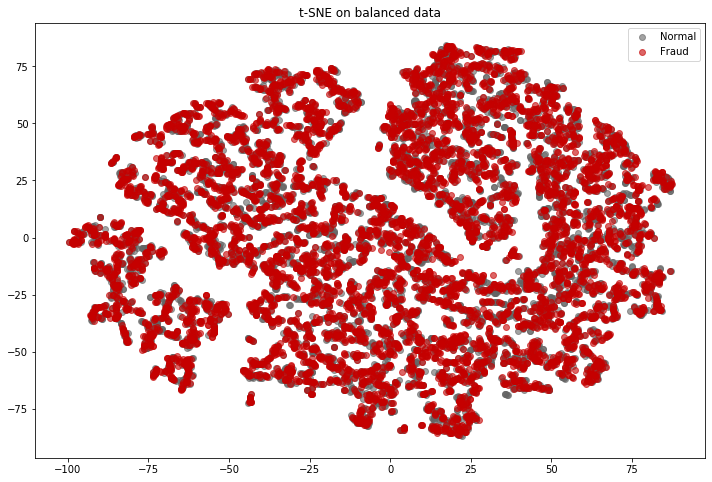

In [49]:
from sklearn.manifold import TSNE
 
def tsne_plot(x, y):
    tsne = TSNE(n_components=2, random_state=2020)
    X_t = tsne.fit_transform(x)
 
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], 
                marker='o', color=(100/255, 100/255, 100/255), 
                linewidth='1', alpha=0.6, label='Normal')
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], 
                marker='o', color=(198/255, 0.0, 0.0), linewidth='1', 
                alpha=0.6, label='Fraud')
     
    plt.title("t-SNE on balanced data")
    plt.legend(loc='best');
    plt.show();
 
# CMS1_x = CMS_final1.drop(['fraud', 'npi', 'nppes_provider_gender', 'provider_type'], axis = 1).values
# CMS1_y = CMS_final1['fraud'].values
CMS1_x = CMS1.drop(['fraud', 'npi'], axis = 1).sample(15000).values
CMS1_y = CMS1['fraud'].sample(15000).values
     
tsne_plot(CMS1_x, CMS1_y)

### PCA Plots

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [58]:
# Standardization

# scaler = StandardScaler()
# num_cols = CMS_final1.columns.tolist()[3:-1] # cols to standardize
# CMS_finalstd = CMS_final1.copy()
# CMS_finalstd[num_cols] = scaler.fit_transform(CMS_finalstd[num_cols])
# CMS_finalstd.drop(columns=['nppes_provider_gender', 'provider_type'], inplace=True)
# CMS_finalstd.head()
# CMS1_std

scaler = StandardScaler()

num_cols = CMS1.columns.tolist()[1:48] # cols to standardize
CMS1_std = CMS1.copy()
CMS1_std[num_cols] = scaler.fit_transform(CMS1_std[num_cols])
CMS1_std.head()

,npi,hcpcs_code_nunique,line_srvc_cnt_sum,line_srvc_cnt_mean,line_srvc_cnt_std,line_srvc_cnt_min,line_srvc_cnt_max,bene_unique_cnt_sum,bene_unique_cnt_mean,bene_unique_cnt_std,bene_unique_cnt_min,bene_unique_cnt_max,bene_day_srvc_cnt_sum,bene_day_srvc_cnt_mean,bene_day_srvc_cnt_std,bene_day_srvc_cnt_min,bene_day_srvc_cnt_max,average_submitted_chrg_amt_sum,average_submitted_chrg_amt_mean,average_submitted_chrg_amt_std,average_submitted_chrg_amt_min,average_submitted_chrg_amt_max,average_Medicare_payment_amt_sum,average_Medicare_payment_amt_mean,average_Medicare_payment_amt_std,average_Medicare_payment_amt_min,average_Medicare_payment_amt_max,hcpcs_drug_indicator_D,place_of_service_F,total_claim_count_sum,total_claim_count_mean,total_claim_count_std,total_claim_count_min,total_claim_count_max,total_30_day_fill_count_sum,total_30_day_fill_count_mean,total_30_day_fill_count_std,total_30_day_fill_count_min,total_30_day_fill_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_std,total_day_supply_min,total_day_supply_max,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_std,total_drug_cost_min,total_drug_cost_max,nppes_provider_gender_M,provider_type_Advanced Heart Failure and Transplant Cardiology,provider_type_Allergy/ Immunology,provider_type_Anesthesiology,provider_type_Anesthesiology Assistant,provider_type_Cardiac Surgery,provider_type_Cardiology,provider_type_Certified Clinical Nurse Specialist,provider_type_Certified Nurse Midwife,provider_type_Certified Registered Nurse Anesthetist (CRNA),provider_type_Chiropractic,provider_type_Clinic or Group Practice,provider_type_Clinical Cardiac Electrophysiology,provider_type_Colorectal Surgery (Proctology),provider_type_Critical Care (Intensivists),provider_type_Dentist,provider_type_Dermatology,provider_type_Diagnostic Radiology,provider_type_Emergency Medicine,provider_type_Endocrinology,provider_type_Family Practice,provider_type_Gastroenterology,provider_type_General Practice,provider_type_General Surgery,provider_type_Geriatric Medicine,provider_type_Geriatric Psychiatry,provider_type_Gynecological Oncology,provider_type_Hand Surgery,provider_type_Hematology,provider_type_Hematology-Oncology,provider_type_Hospice and Palliative Care,provider_type_Hospitalist,provider_type_Infectious Disease,provider_type_Internal Medicine,provider_type_Interventional Cardiology,provider_type_Interventional Pain Management,provider_type_Interventional Radiology,provider_type_Licensed Clinical Social Worker,provider_type_Mass Immunizer Roster Biller,provider_type_Maxillofacial Surgery,provider_type_Medical Oncology,provider_type_Nephrology,provider_type_Neurology,provider_type_Neuropsychiatry,provider_type_Neurosurgery,provider_type_Nuclear Medicine,provider_type_Nurse Practitioner,provider_type_Obstetrics & Gynecology,provider_type_Occupational Therapist in Private Practice,provider_type_Ophthalmology,provider_type_Optometry,provider_type_Oral Surgery (Dentist only),provider_type_Orthopedic Surgery,provider_type_Osteopathic Manipulative Medicine,provider_type_Otolaryngology,provider_type_Pain Management,provider_type_Pathology,provider_type_Pediatric Medicine,provider_type_Peripheral Vascular Disease,provider_type_Physical Medicine and Rehabilitation,provider_type_Physical Therapist in Private Practice,provider_type_Physician Assistant,provider_type_Plastic and Reconstructive Surgery,provider_type_Podiatry,provider_type_Preventive Medicine,provider_type_Psychiatry,"provider_type_Psychologist, Clinical",provider_type_Pulmonary Disease,provider_type_Radiation Oncology,provider_type_Rheumatology,provider_type_Sleep Medicine,provider_type_Speech Language Pathologist,provider_type_Sports Medicine,provider_type_Surgical Oncology,provider_type_Thoracic Surgery,provider_type_Undefined Physician type,provider_type_Unknown Supplier/Provider Specialty,provider_type_Urology,provider_type_Vascular Surgery,fraud
0,1003000126,0.0045,-0.0984,-0.0297,-0.0730,-0.2161,-0.0878,0.2485,0.8186,

In [61]:
# PCA
pca = PCA(n_components=CMS1_std.drop(labels=['npi', 'fraud'], axis = 1).shape[1])  

pca.fit(CMS1_std.drop(labels=['npi', 'fraud'], axis = 1)) 


PCA(n_components=127)

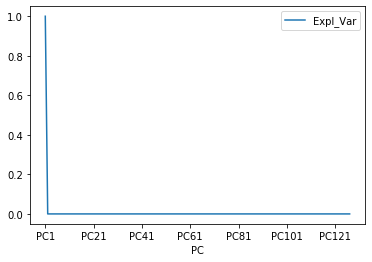

In [62]:
# Plot variance of PC's

x=[]
y=[]

for i in range(pca.n_components_):
    #print('PC{}: {}'.format(i+1,pca.explained_variance_ratio_[i]))
    s='PC' + str(i+1)
    x.append(s)
    y.append(pca.explained_variance_ratio_[i])

t = pd.DataFrame({'PC': x, 'Expl_Var': y})
t.head()
t.plot(x='PC', y='Expl_Var', kind='line')

In [63]:
CMS1_std_pca = pd.DataFrame(pca.transform(CMS1_std.drop(labels=['npi', 'fraud'], axis = 1)))
#columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']) 
CMS1_std_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126
0,-44638.8287,-1.2002,1.9341,1.2846,-1.0614,-1.2017,-0.6120,2.5293,-0.1420,0.0948,-0.4969,-0.8148,0.0935,-0.6575,0.1265,0.2071,0.2550,0.2839,0.0804,-0.0795,0.2996,-0.2072,-0.2930,-0.1248,0.0503,-0.4455,-0.0341,-0.0735,0.0735,0.6455,0.4140,0.2096,-0.1843,-0.0812,0.0303,0.0893,0.0242,-0.0653,0.1060,-0.0794,-0.0315,-0.0815,0.0620,-0.0134,-0.0200,-0.0152,0.0195,-0.0143,-0.0254,-0.0093,0.0127,-0.0222,0.0074,-0.0104,-0.0016,0.0028,0.0519,0.0046,0.0126,-0.0126,-0.0189,0.0140,-0.0137,0.0133,-0.0253,-0.0123,-0.0274,0.0050,0.0103,-0.0205,0.0041,-0.0149,-0.0184,-0.0027,-0.0161,-0.0023,-0.0073,0.0077,0.0072,0.0078,-0.0199,0.0144,0.0161,-0.0042,0.0092,0.0081,0.0038,-0.0019,0.0036,0.0041,0.0080,-0.0020,-0.0002,-0.0073,-0.0007,-0.0030,-0.0015,-0.0027,-0.0019,-0.0020,-0.0004,-0.0036,0.0029,-0.0004,-0.0020,-0.0010,0.0001,-0.0015,-0.0003,-0.0007,-0.0005,-0.0002,-0.0005,-0.0002,-0.0001,-0.0001,-0.0001,0.0001,-0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000
1,-35595.6287,-0.6367,-0.2297,0.2899,0.2151,-0.2824,-0.6109,0.2422,-0.5400,0.3270,0.4330,0.9787,-0.1129,-0.6764,-0.0333,0.0460,-0.0411,0.1228,-0.0291,-0.1078,0.1354,0.2071,0.1421,0.3462,-0.8041,0.2869,-0.1296,-0.1175,-0.0102,-0.0321,-0.5174,0.4801,-0.2988,0.0615,-0.0233,0.0724,0.1564,-0.1582,0.0397,-0.0644,-0.0693,0.1049,-0.0706,0.0356,0.0465,-0.0078,0.0065,-0.0340,-0.0331,-0.0078,0.0558,-0.0003,-0.0109,-0.0485,0.0039,0.0111,-0.0235,0.0062,-0.0146,-0.0004,0.0297,0.0151,-0.0026,0.0098,0.0067,-0.0063,0.0467,0.0137,0.0390,-0.0094,0.0047,0.0252,0.0181,-0.0050,0.0040,-0.0013,-0.0098,-0.0042,-0.0069,0.0003,0.0081,-0.0113,-0.0020,-0.0032,0.0107,0.0215,-0.0101,0.0019,0.0017,-0.0006,-0.0035,-0.0023,0.0007,0.0020,0.0012,0.0029,0.0008,-0.0016,0.0027,0.0010,0.0009,0.0000,0.0065,0.0005,0.0005,0.0001,0.0006,0.0005,0.0004,0.0007,0.0001,0.0001,0.0002,0.0002,-0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000
2,-14329.7287,1.6136,-2.2582,-1.7867,0.4940,0.5183,-0.0311,0.1984,0.5906,-0.3838,-0.0120,-0.2032,0.1741,0.3230,-1.0495,-0.1728,0.1792,0.7889,-0.5085,-0.9767,0.0838,-0.3457,0.2408,0.1897,0.1070,-0.3150,0.2785,-0.0415,-0.2291,-0.6586,0.4046,0.2730,-0.0724,0.0267,0.0329,0.1345,0.0488,0.0517,-0.0927,0.0842,0.0131,-0.0147,-0.0410,-0.1274,0.0189,-0.0018,0.0291,0.0306,0.0381,0.0179,0.0060,0.0539,-0.0112,0.0325,-0.0118,0.0294,0.0126,-0.0192,-0.0105,0.0099,0.0125,0.0239,-0.0022,-0.0028,0.0134,0.0116,0.0051,-0.0072,-0.0041,0.0079,-0.0056,-0.0032,-0.0025,-0.0008,0.0028,-0.0007,0.0133,0.0158,0.0023,-0.0039,-0.0073,0.0149,0.0083,-0.0063,0.0101,0.0137,-0.0061,-0.0003,0.0008,-0.0029,-0.0057,0.0013,-0.0003,0.0011,0.0005,0.0015,0.0002,0.0008,0.0001,0.0000,0.0010,-0.0008,0.0112,0.0003,0.0011,-0.0000,0.0004,0.0000,0.0001,0.0003,0.0000,-0.0000,0.0001,-0.0001,0.0001,-0.0001,0.0000,0.0001,0.0000,0.0001,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,59654.9113,6.2124,-1.1777,-2.2692,0.9277,0.1359,1.3852,-0.9703,1.4465,-0.5109,-2.7933,-0.6470,1.8698,0.4408,-0.2156,-0.4537,0.5022,0.9373,-0.6427,-0.0274,0.8676,-0.0182,-0.7987,-0.2000,-0.0883,-0.3229,-0.9413,-0.5666,0.2005,-0.2061,-0.2773,0.0624,0.1529,-0.5424,-0.3373,-0.0473,-0.1447,0.1744,0.1204,0.1924,0.3457,0.1690,0.0452,0.3034,0.0235,0.0150,-0.1156,-0.0968,-0.4019,0.1842,0.2028,-0.3224,0.0985,-0.2056,-0.0241,-0.0739,-0.0040,-0.0767,-0.0048,-0.0007,0.0652,0.0079,-0.0058,-0.0236,-0.0309,0.0279,0.0305,-0.0053,-0.0417,0.0056,-0.0028,-0.0188,-0.0697,0.0126,0.0076,0.0105,0.0177,0.0021,-0.0040,-0.0070,0.0088,-0.0112,-0.0030,-0.0254,0.0134,0.0227,-0.0141,0.0020,0.0056,0.0128,0.0112,0.0030,0.0013,0.0008,0.0009,0.0021,0.0003,0.004

<Figure size 432x288 with 0 Axes>

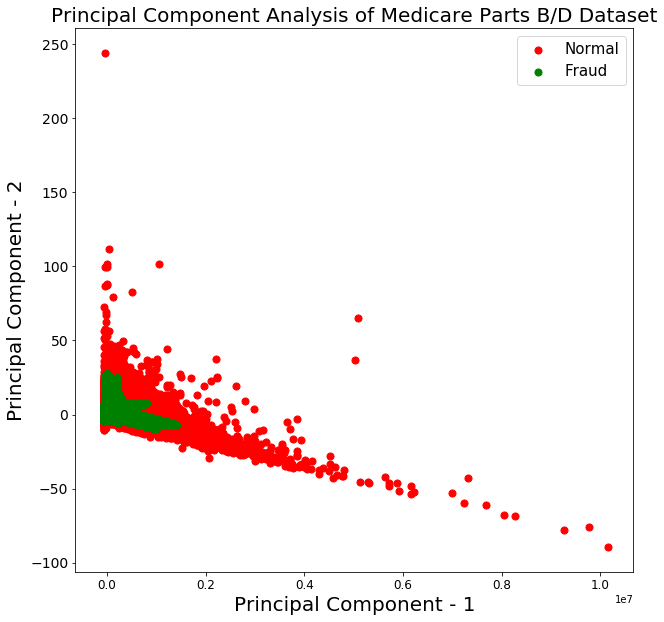

In [64]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Medicare Parts B/D Dataset",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = CMS_finalstd['fraud'] == target
    plt.scatter(CMS1_std_pca.loc[indicesToKeep, 0]
               , CMS1_std_pca.loc[indicesToKeep, 1], c = color, s = 50)

plt.legend(['Normal', 'Fraud'], prop={'size': 15})

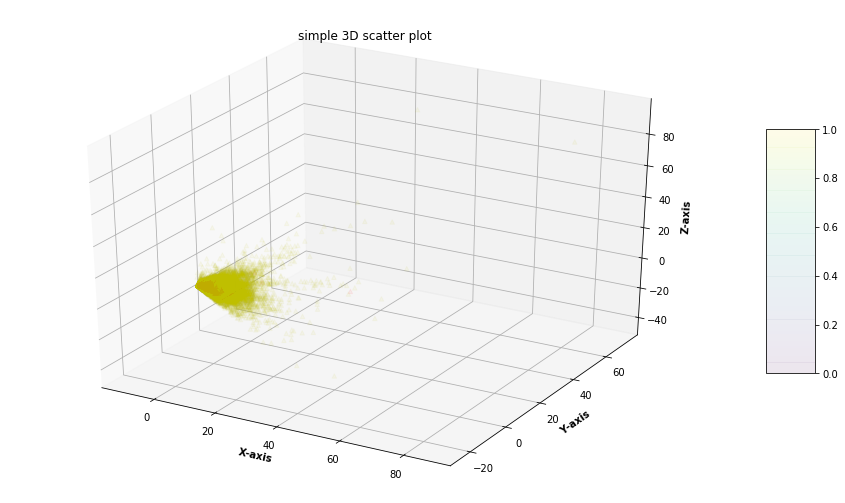

In [203]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
z = 4 * np.tan(np.random.randint(10, size =(500))) + np.random.randint(100, size =(500))
x = 4 * np.cos(z) + np.random.normal(size = 500)
y = 4 * np.sin(z) + 4 * np.random.normal(size = 500)
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
targets = [0, 1]
colors = ['y', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = CMS_finalstd['fraud'] == target
    sctt = ax.scatter3D(CMS_finalstd_pca.loc[indicesToKeep, 0], CMS_finalstd_pca.loc[indicesToKeep, 1], CMS_finalstd_pca.loc[indicesToKeep, 2],
                        alpha = 0.05,
                        c = color, 
                        #cmap = my_cmap, 
                        marker ='^')
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

### Corr Matrix

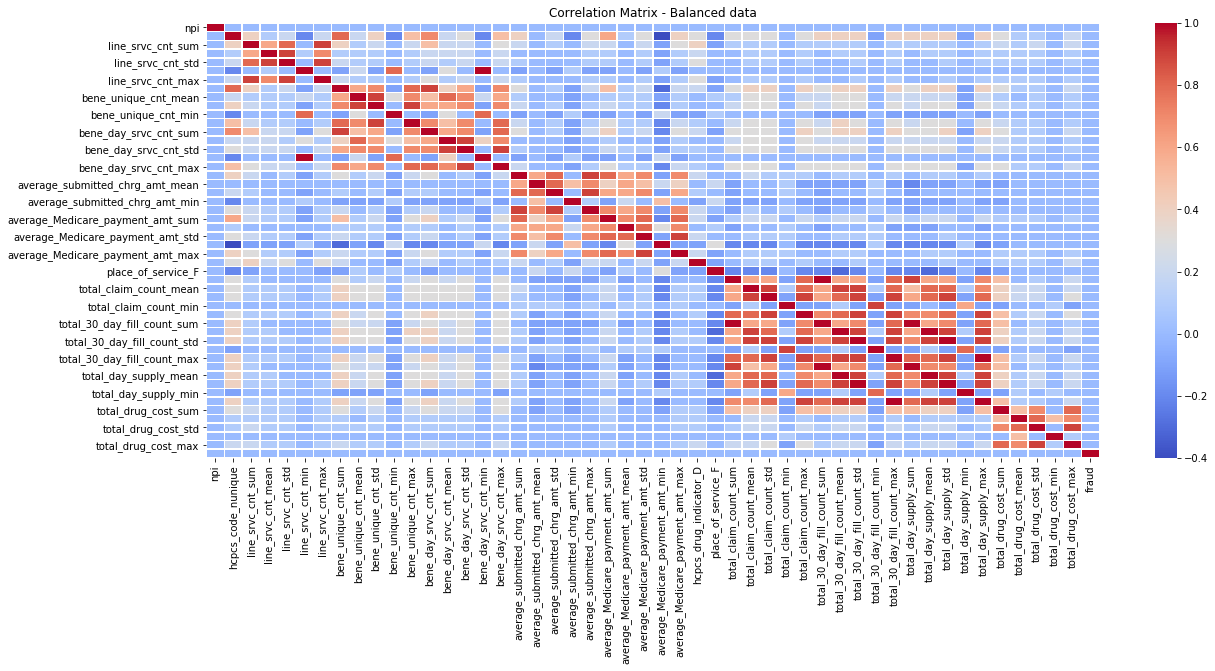

In [80]:
import seaborn as sns
corr = CMS_final1.corr()
 
plt.figure(figsize=(20,8))
fig = sns.heatmap(corr.round(1), cmap='coolwarm', linewidths=.5)
fig.set(title="Correlation Matrix - Balanced data");
plt.show()

In [66]:
def hist_norm_fraud(normal, fraud, bins=20, title='Title', 
                    xlabel='xlabel', ylabel='ylabel'):
    plt.figure(figsize=(14, 6))
    plt.hist((normal), bins, alpha=0.6, density=True, 
             label='Normal', color=(100/255, 100/255, 100/255))
    plt.hist((fraud), bins, alpha=0.6, density=True, 
             label='Fraud', color=(198/255, 0.0, 0.0))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right', frameon=False)
    plt.show()

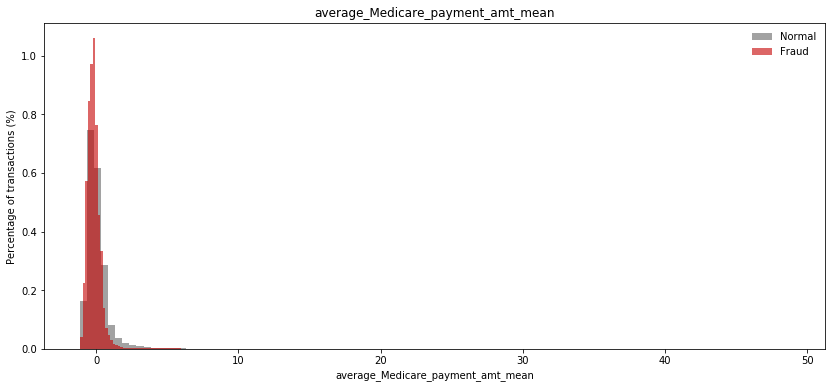

In [67]:
hist_norm_fraud(CMS1_std['average_Medicare_payment_amt_mean'][CMS1_std.fraud==0], CMS1_std['average_Medicare_payment_amt_mean'][CMS1_std.fraud==1],
                bins=100,
                title="average_Medicare_payment_amt_mean",
                xlabel="average_Medicare_payment_amt_mean",
                ylabel="Percentage of transactions (%)")

Plotting Figure 1
Plotting Figure 2


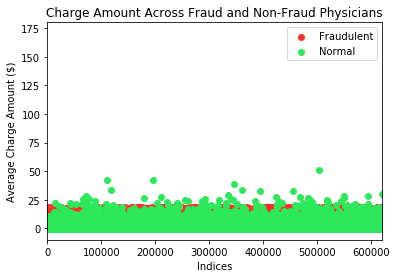

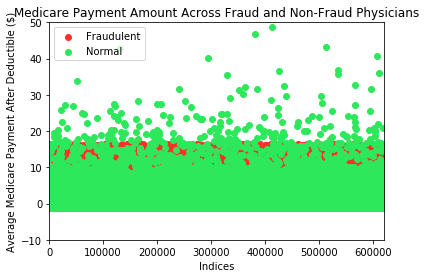

In [68]:
# EXPLORATORY DATA ANALYSIS

end = len(CMS1_std.loc[CMS1_std.fraud == 1])
ind = np.arange(0, end, 1)

print('Plotting Figure 1')
plt.figure()
plt.scatter(ind, CMS1_std["average_submitted_chrg_amt_sum"].loc[CMS1_std.fraud == 1], c='#FF3028', label="Fraudulent")
plt.scatter(ind, CMS1_std["average_submitted_chrg_amt_sum"].loc[CMS1_std.fraud == 0].iloc[ind], c='#2EE85B', label="Normal")
plt.title("Charge Amount Across Fraud and Non-Fraud Physicians")
plt.xlabel("Indices")
plt.ylabel("Average Charge Amount ($)")
plt.xlim(0, end)
plt.ylim(-10, 180)
plt.legend()
print('Plotting Figure 2')
plt.figure()
plt.scatter(ind, CMS1_std['average_Medicare_payment_amt_mean'].loc[CMS1_std.fraud == 1], c='#FF3028', label="Fraudulent")
plt.scatter(ind, CMS1_std['average_Medicare_payment_amt_mean'].loc[CMS1_std.fraud == 0].iloc[ind], c='#2EE85B', label="Normal")
plt.title("Medicare Payment Amount Across Fraud and Non-Fraud Physicians")
plt.xlabel("Indices")
plt.ylabel("Average Medicare Payment After Deductible ($)")
plt.xlim(0, end)
plt.ylim(-10, 50)
plt.legend()

Plotting Figure 1
Plotting Figure 2


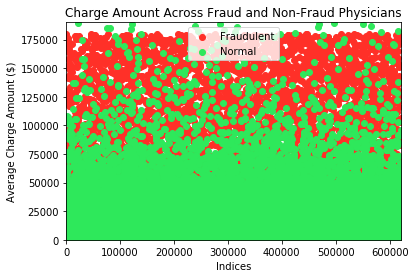

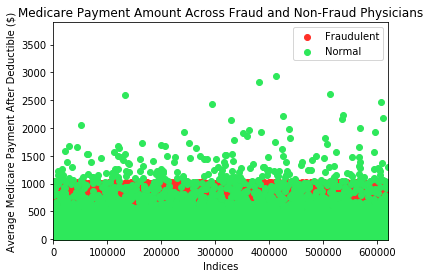

In [77]:
# EXPLORATORY DATA ANALYSIS

end = len(CMS1.loc[CMS1.fraud == 1])
ind = np.arange(0, end, 1)

print('Plotting Figure 1')
plt.figure()
plt.scatter(ind, CMS1["average_submitted_chrg_amt_sum"].loc[CMS1.fraud == 1], c='#FF3028', label="Fraudulent")
plt.scatter(ind, CMS1["average_submitted_chrg_amt_sum"].loc[CMS1.fraud == 0].iloc[ind], c='#2EE85B', label="Normal")
plt.title("Charge Amount Across Fraud and Non-Fraud Physicians")
plt.xlabel("Indices")
plt.ylabel("Average Charge Amount ($)")
plt.xlim(0, end)
plt.ylim(-10, 190000)
plt.legend()
print('Plotting Figure 2')
plt.figure()
plt.scatter(ind, CMS1['average_Medicare_payment_amt_mean'].loc[CMS1.fraud == 1], c='#FF3028', label="Fraudulent")
plt.scatter(ind, CMS1['average_Medicare_payment_amt_mean'].loc[CMS1.fraud == 0].iloc[ind], c='#2EE85B', label="Normal")
plt.title("Medicare Payment Amount Across Fraud and Non-Fraud Physicians")
plt.xlabel("Indices")
plt.ylabel("Average Medicare Payment After Deductible ($)")
plt.xlim(0, end)
plt.ylim(-10, 3900)
plt.legend()

In [197]:
# balance RUS dataset

CMS_final2.to_csv('../data/processed_data/CMS.csv')

In [40]:
# Smote dataset

CMS1.to_csv('../data/processed_data/CMS1.csv')